# Bibliotecas e configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PyBCOPS as pb

from sklearn.ensemble import RandomForestClassifier

np.random.seed(123)

# Gerando o conjunto de dados

In [2]:
X_train = np.zeros((1000, 10))
y_train = np.zeros(1000, dtype = int)

X_test = np.zeros((1500, 10))
y_test = np.zeros(1500, dtype = int)

for i in range(500):
    ## Dados para o treino
    # Classe 0
    X_train[i,:] = np.random.normal(0, 1, 10)
    y_train[i] = 0
    
    # Classe 1
    X_train[i + 500,] = np.concatenate([np.random.normal(3, 0.5, 1), np.random.normal(0, 1, 9)])
    y_train[i + 500] = 1
    
    ## Dados para o teste
    # Classe 0
    X_test[i,:] = np.random.normal(0, 1, 10)
    y_test[i] = 0
    
    # Classe 1
    X_test[i + 500,:] = np.concatenate([np.random.normal(3, 0.5, 1), np.random.normal(0, 1, 9)])
    y_test[i + 500] = 1
    
    # Classe 2 (outliers)
    X_test[i + 1000,:] = np.concatenate([np.random.normal(0, 1, 1),
                                        np.random.normal(3, 0.5, 1),
                                        np.random.normal(0, 1, 8)])
    y_test[i + 1000] = 2

## Visualização do conjunto de treinamento

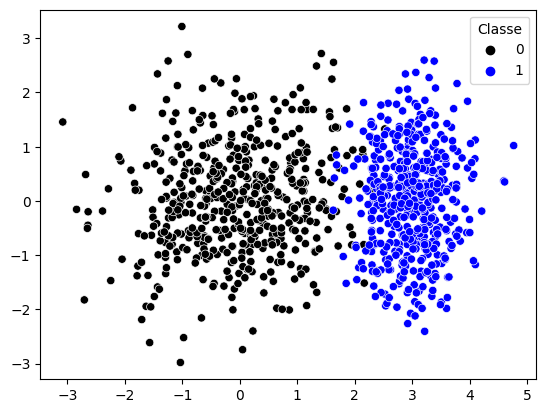

In [3]:
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = y_train, palette=['black', 'blue'])
plt.legend(title = "Classe")
plt.show()

## Visualização do conjunto de teste

Perceba que o conjunto de teste possui uma classe que seguem um padrão diferente das presentes no conjunto de treinamento. As observações dessa classe devem ser consideradas como atípicas pelo algoritmo BCOPS.

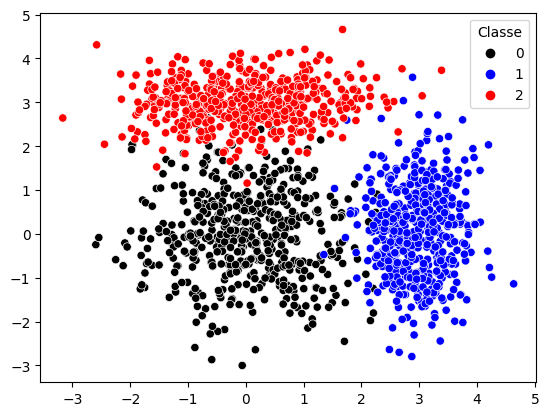

In [4]:
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = y_test, palette=['black', 'blue', 'red'])
plt.legend(title = "Classe")
plt.show()

# Método BCOPS

## Treinamento utilizando o algoritmo Floresta Aleatória

In [5]:
prediction_conformal = pb.BCOPS(RandomForestClassifier, X_train, y_train, X_test)

## Visualização das classes preditas

$C\left(x\right)$ é o conjunto com as possíveis classes as quais uma observação $x$ pode pertencer.

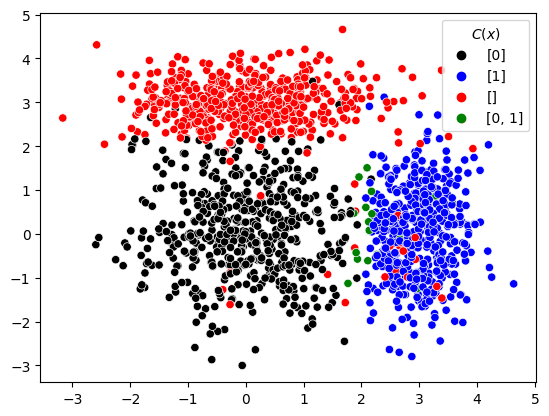

In [6]:
alpha = 1-0.95
labels = np.unique(y_train)
y_pred = pb.prediction_sets(prediction_conformal, labels, alpha)

sets = [str(i) for i in y_pred]
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = sets, palette=['black', 'blue', 'red', 'green'])
plt.legend(title = r"$C\left(x\right)$")
plt.show()

## Matriz de confusão e taxa de detecção de observações atípicas

As linhas indicam a classe verdadeira e as colunas indicam a classe predita no conjunto de teste.

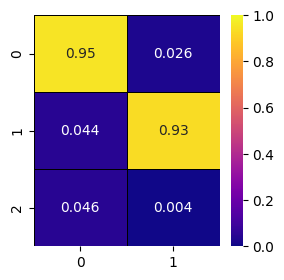

In [7]:
evaluation = pb.evaluate_conformal(prediction_conformal, y_test, labels)
plt.figure(figsize=(3, 3))
sns.heatmap(evaluation, vmin=0, vmax=1, cmap="plasma", annot=True, linewidths=0.5, linecolor="black")
plt.show()

Podemos notar que aproximadamente $95\%$ das observações cujas classes estavam presentes durante o treinamento são classificadas corretamente.

In [8]:
pb.abstention_rate(y_pred, y_test, labels)

0.95

Temos ainda uma taxa de detecção de observações atípicas de $95\%$